# 🖼️ Multimodal AI: Teaching Computers to See

**Scenario:** Imagine you're building an app for restaurant owners. They take photos of their dishes, and your app automatically generates menu descriptions, identifies ingredients, and even suggests pricing based on similar dishes. This is the power of **multimodal AI** — models that can understand both text and images.

In this notebook, you'll learn how to:
- Send images to AI models for analysis
- Extract text from images (OCR)
- Analyze charts and graphs
- Compare multiple images
- Build practical vision-powered applications

---

## 🎯 What You'll Build

By the end of this notebook, you'll understand how to:
1. **Image Description** - Get AI to describe what's in a photo
2. **OCR (Text Extraction)** - Pull text from images
3. **Chart Analysis** - Understand graphs and visualizations
4. **Image Comparison** - Find differences between photos
5. **Real-world Applications** - Menu generator, receipt scanner, UI analyzer

---

## 📦 Setup: Install Required Packages

We'll use:
- **`litellm`** - Works with vision-enabled models (Gemini, GPT-4o, Claude)
- **`python-dotenv`** - Load API keys
- **`pillow`** - Work with images
- **`requests`** - Download sample images

In [1]:
# Install required packages
!pip install -q litellm python-dotenv pillow requests

## 🔑 Configuration: Set Up Your API Key

**Important:** Not all models support vision! You need a **vision-enabled model**:
- **Google Gemini**: `gemini/gemini-2.5-flash` (free tier available)
- **OpenAI**: `gpt-4o`, `gpt-4o-mini` (paid)
- **Anthropic**: `claude-3-5-sonnet-20241022` (paid)

For this notebook, we'll use **Gemini 2.0 Flash** (free and excellent for vision).

In [2]:
import os
from dotenv import load_dotenv

# Load API key from .env file (if it exists)
load_dotenv()

# Configuration
DEFAULT_MODEL = os.getenv("DEFAULT_MODEL")
DEFAULT_TEMPERATURE = 0.7
DEFAULT_MAX_TOKENS = 500

print(f"✅ Using model: {DEFAULT_MODEL}")

✅ Using model: openrouter/google/gemini-2.0-flash-001


## 🛠️ Helper Functions: Our Vision AI Toolkit

Let's create functions to send images to AI models.

In [3]:
from litellm import completion
from typing import Optional, List
from PIL import Image
import base64
import io
import requests

import litellm
import logging

litellm.suppress_debug_info = True
logging.getLogger("litellm").setLevel(logging.CRITICAL)

# Initialize

def image_to_base64(image: Image.Image) -> str:
    """Convert PIL Image to base64 string."""
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    img_bytes = buffered.getvalue()
    return base64.b64encode(img_bytes).decode('utf-8')

def analyze_image(
    prompt: str,
    images: List[Image.Image],
    system_message: Optional[str] = None,
    temperature: float = DEFAULT_TEMPERATURE,
    max_tokens: int = DEFAULT_MAX_TOKENS
) -> str:
    """
    Analyze images with a text prompt.
    
    Args:
        prompt: Your question about the image(s)
        images: List of PIL Images
        system_message: Optional personality/role for the AI
        temperature: 0.0 = consistent, 1.0 = creative
        max_tokens: Maximum length of response
    
    Returns:
        AI's analysis as a string
    """
    # Build message content with text and images
    content = [{"type": "text", "text": prompt}]
    
    for img in images:
        base64_image = image_to_base64(img)
        content.append({
            "type": "image_url",
            "image_url": {
                "url": f"data:image/png;base64,{base64_image}"
            }
        })
    
    messages = []
    if system_message:
        messages.append({"role": "system", "content": system_message})
    
    messages.append({"role": "user", "content": content})
    
    response = completion(
        model=DEFAULT_MODEL,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens
    )
    
    return response.choices[0].message.content

def download_image(url: str) -> Image.Image:
    """Download an image from a URL."""
    response = requests.get(url)
    return Image.open(io.BytesIO(response.content))

def create_sample_text_image(text: str, size=(400, 200)) -> Image.Image:
    """Create a simple image with text (for OCR demo)."""
    from PIL import ImageDraw, ImageFont
    img = Image.new('RGB', size, color='white')
    draw = ImageDraw.Draw(img)
    # Use default font
    draw.text((20, 80), text, fill='black')
    return img

print("✅ Helper functions loaded!")

✅ Helper functions loaded!


---

## 🍕 Part 1: Image Description (Food Photo Analysis)

**Scenario:** A restaurant owner uploads a photo of their new pasta dish. Your app needs to generate an appetizing menu description.

Let's use a sample food image from the internet.

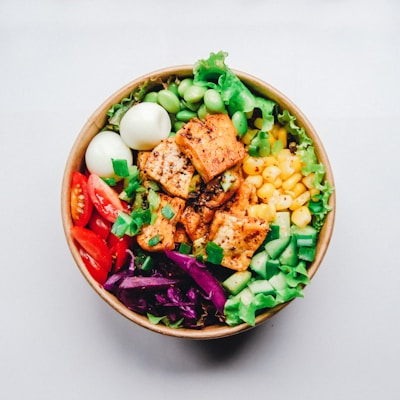

[Prompt:] Describe this dish in detail. What ingredients can you see? Make it sound appetizing for a restaurant menu.

✓ AI Description:

Here's a description of the dish, written to entice customers on a restaurant menu:

**Zen Garden Bowl**

Embark on a culinary journey to inner peace with our Zen Garden Bowl. Imagine a vibrant landscape of fresh, wholesome ingredients, thoughtfully arranged for a symphony of flavors and textures.

At the heart of this bowl you will find golden-brown, pan-seared tofu cubes, marinated in a secret blend of Asian spices, offering a satisfyingly chewy and savory experience. Nestled beside the tofu are juicy, sun-ripened cherry tomatoes bursting with sweetness and a pop of color. Sweet kernels of golden corn bring a touch of sunshine, while crisp, diced cucumbers provide a cool and refreshing contrast. 

For added protein and richness, we've included creamy, perfectly cooked quail eggs, offering a delicate and luxurious bite. Bright green edamame bring a 

In [14]:
# Download a sample food image
food_image_url = "https://images.unsplash.com/photo-1546069901-ba9599a7e63c?w=400"
food_image = download_image(food_image_url)

# Display the image
display(food_image)

# Ask AI to describe it
prompt = "Describe this dish in detail. What ingredients can you see? Make it sound appetizing for a restaurant menu."

print(f"[Prompt:] {prompt}\n")

description = analyze_image(prompt, [food_image])
print(f"✓ AI Description:\n\n{description}")

### ❓ Discussion Question #1

The AI described the dish based on visual cues. What details did it get right? What might it have missed? How could you improve the prompt to get more specific information (e.g., estimated calories, dietary restrictions)?

---

## 📄 Part 2: OCR (Extracting Text from Images)

**Scenario:** A customer sends you a photo of a handwritten note or a receipt. You need to extract the text.

**What is OCR?** OCR stands for "Optical Character Recognition." It means reading text from images. For example, taking a photo of a business card and extracting the name, phone number, and email.

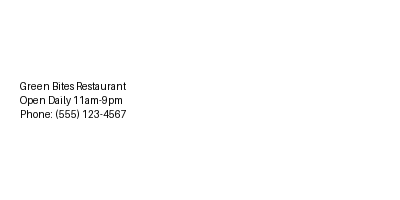

[Prompt:] Extract all the text from this image. Return it exactly as it appears.

✓ Extracted Text:
Green Bites Restaurant
Open Daily 11am-9pm
Phone: (555) 123-4567



In [15]:
# Create a sample image with text
text_image = create_sample_text_image("Green Bites Restaurant\nOpen Daily 11am-9pm\nPhone: (555) 123-4567")

# Display the image
display(text_image)

# Extract text from the image
prompt = "Extract all the text from this image. Return it exactly as it appears."

print(f"[Prompt:] {prompt}\n")

extracted_text = analyze_image(prompt, [text_image])
print(f"✓ Extracted Text:\n{extracted_text}")

### 💡 Key Insight

Vision models can read text from images, even handwritten text! This is incredibly useful for:
- **Receipts**: Extract items and prices
- **Business Cards**: Get contact information
- **Documents**: Digitize scanned papers
- **Screenshots**: Extract text from app interfaces

---

## 📊 Part 3: Chart Analysis (Understanding Data Visualizations)

**Scenario:** Your restaurant has a sales chart showing revenue over the past 6 months. You want AI to analyze trends and give insights.

**What this means:** Instead of manually looking at a graph and writing a report, AI can do it for you. For example, "Sales increased 20% in March" or "Weekend sales are higher than weekdays."

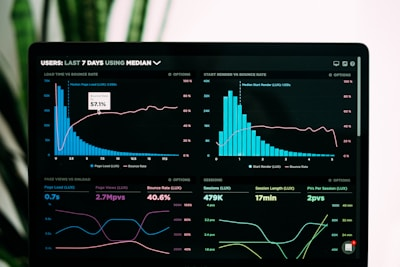

[Prompt:] Analyze this chart. What are the key trends? What insights can you provide? Summarize in 3-4 sentences.

✓ Chart Analysis:
Based on the provided information, the key trends appear to relate to website performance and user engagement over the last 7 days. There is a relationship between page load time and bounce rate, with a median page load time of 0.7s and a bounce rate of 40.6%. The website has had 479K sessions with an average session length of 17 minutes and 2 page views per session. Further analysis would be needed of the full graphs to determine the exact nature of the correlations and potential areas for improvement.



In [6]:
# Use a sample chart image
chart_url = "https://images.unsplash.com/photo-1551288049-bebda4e38f71?w=400"
chart_image = download_image(chart_url)

# Display the chart
display(chart_image)

# Ask AI to analyze it
prompt = "Analyze this chart. What are the key trends? What insights can you provide? Summarize in 3-4 sentences."

print(f"[Prompt:] {prompt}\n")

analysis = analyze_image(prompt, [chart_image])
print(f"✓ Chart Analysis:\n\n{analysis}")

### 🎯 Challenge Task #1: Extract Specific Data

Try asking the AI to extract specific numbers from a chart:
- "What was the value in March?"
- "Which month had the highest sales?"
- "Calculate the percentage change from January to June."

Test how accurate the AI is at reading precise values from visualizations.

In [7]:
# Your experimentation space for Challenge #1

# Example:
# specific_prompt = "What was the highest value shown in this chart?"
# result = analyze_image(specific_prompt, [chart_image])
# print(result)

---

## 🔍 Part 4: Image Comparison (Spot the Differences)

**Scenario:** A restaurant remodeled their dining area. They have before and after photos. You want AI to describe the changes.

**What this means:** Instead of manually comparing two photos, AI can tell you: "The walls are now blue instead of white," "New lighting fixtures were added," etc.

Image 1:


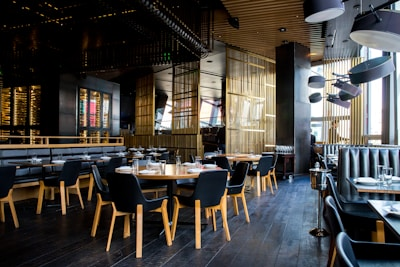


Image 2:


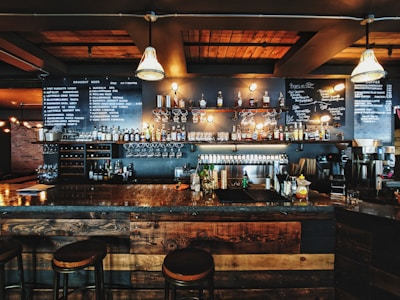


[Prompt:] Compare these two restaurant interiors. What are the key differences in style, atmosphere, and design? List 3-5 specific differences.

✓ Comparison:

Here's a comparison of the two restaurant interiors, highlighting key differences:

1.  **Formality vs. Informality:** The first image depicts a more formal and upscale dining environment. The use of dark woods, structured seating arrangements, and defined spaces suggests a higher-end experience. In contrast, the second image portrays a more relaxed and casual atmosphere. The exposed bar, rustic wood, visible piping, and chalkboard menu give it a more informal feel, likely geared toward a quick bite or a social gathering.
2.  **Lighting:** The first restaurant utilizes a combination of natural light and strategically placed spotlights to create a refined ambiance. The lighting is generally softer and more diffused. The second restaurant features brighter, more functional lighting, with exposed bulbs and task lighting over the b

In [18]:
# Download two similar images for comparison
image1_url = "https://images.unsplash.com/photo-1517248135467-4c7edcad34c4?w=400"  # Restaurant interior
image2_url = "https://images.unsplash.com/photo-1514933651103-005eec06c04b?w=400"  # Another restaurant

image1 = download_image(image1_url)
image2 = download_image(image2_url)

# Display both images
print("Image 1:")
display(image1)
print("\nImage 2:")
display(image2)

# Compare them
prompt = "Compare these two restaurant interiors. What are the key differences in style, atmosphere, and design? List 3-5 specific differences."

print(f"\n[Prompt:] {prompt}\n")

comparison = analyze_image(prompt, [image1, image2])
print(f"✓ Comparison:\n\n{comparison}")

### ❓ Discussion Question #2

AI can compare images and spot differences. What are some practical applications for this?

Think about:
- Quality control in manufacturing (comparing products)
- Medical imaging (comparing X-rays over time)
- Real estate (comparing property conditions)
- Fashion (comparing outfit styles)

---

## 💼 Real-World Applications

Now let's build complete, practical examples you can use in real projects.

### 1. Menu Description Generator
**What it does:** Upload a food photo → Get an appetizing menu description

**How to build it:**
- Use a system instruction to set the tone (professional, casual, fancy)
- Ask for specific details (ingredients, cooking method, taste profile)
- Generate multiple options and pick the best

In [16]:
# Example: Menu Description Generator
system_message = """You are a professional food writer for upscale restaurants. 
Write appetizing, sophisticated menu descriptions that highlight ingredients and cooking techniques.
Keep descriptions to 2-3 sentences."""

# Use the food image from earlier
prompt = "Write a menu description for this dish. Include the main ingredients and make it sound delicious."

print(f"[Generating menu description...]\n")

menu_description = analyze_image(prompt, [food_image], system_message=system_message)
print(f"✓ Menu Description:\n\n{menu_description}")

[Generating menu description...]

✓ Menu Description:

**Zenith Grain Bowl:** A vibrant composition of pan-seared tofu, edamame, sweet corn, and ruby-red tomatoes, all nestled on a bed of crisp lettuce and shredded cabbage. Topped with soft quail eggs and a delicate sesame vinaigrette, this dish is a symphony of textures and flavors.



### 2. Receipt Scanner
**What it does:** Take a photo of a receipt → Extract items, prices, and total

**How to build it:**
- Use OCR to extract text
- Ask for structured output (JSON) with items and prices
- Validate the total matches the sum of items

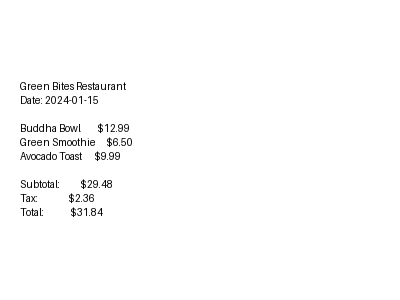


[Extracting receipt data...]

✓ Extracted Data:
Here's the extracted information from the receipt:

*   **Restaurant Name:** Green Bites Restaurant
*   **Date:** 2024-01-15
*   **Items with Prices:**
    *   Buddha Bowl: $12.99
    *   Green Smoothie: $6.50
    *   Avocado Toast: $9.99
*   **Total Amount:** $31.84


In [10]:
# Example: Receipt Scanner
# Create a sample receipt image
receipt_text = """Green Bites Restaurant
Date: 2024-01-15

Buddha Bowl        $12.99
Green Smoothie     $6.50
Avocado Toast      $9.99

Subtotal:          $29.48
Tax:               $2.36
Total:             $31.84"""

receipt_image = create_sample_text_image(receipt_text, size=(400, 300))
display(receipt_image)

prompt = """Extract the following information from this receipt:
- Restaurant name
- Date
- List of items with prices
- Total amount

Format as a clear, structured list."""

print(f"\n[Extracting receipt data...]\n")

receipt_data = analyze_image(prompt, [receipt_image], temperature=0.2)
print(f"✓ Extracted Data:\n{receipt_data}")

### 3. UI Screenshot Analyzer
**What it does:** Analyze app screenshots to describe the interface and suggest improvements

**How to build it:**
- Upload a screenshot of an app or website
- Ask AI to describe the layout, colors, and elements
- Request UX suggestions or accessibility improvements

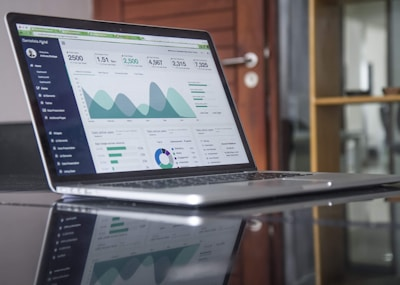


[Analyzing UI...]

✓ UI Analysis:
Okay, let's analyze the UI shown in the image.

**1. Main Elements and Purpose:**

*   **Left Sidebar Navigation:** This is a dark-themed sidebar with icons and text labels. It seems to be the primary navigation for the application, allowing users to switch between different sections or features.
*   **Dashboard/Main Content Area:** This area displays a variety of data visualizations, including:
    *   **Line Chart:** Likely representing a trend over time.
    *   **Bar Chart:** Probably showing comparisons between different categories.
    *   **Pie Chart:** Displaying proportions of a whole.
    *   **Key Metrics (Numbers):** Showing important numerical data (e.g., 2500, 1.51, etc.).
*   **Header:** A very light area at the top with the application name, in this case it seems to be "Sentrals.digital"

**2. What Works Well (UX Perspective):**

*   **Information Density:** The dashboard presents a lot of information in a single view. This can be effi

In [11]:
# Example: UI Screenshot Analyzer
system_message = """You are a UX/UI designer expert. 
Analyze interfaces for usability, accessibility, and design quality.
Provide specific, actionable feedback."""

# Use any website screenshot
ui_url = "https://images.unsplash.com/photo-1460925895917-afdab827c52f?w=400"  # Dashboard/UI image
ui_image = download_image(ui_url)

display(ui_image)

prompt = """Analyze this user interface:
1. What are the main elements and their purpose?
2. What works well from a UX perspective?
3. What could be improved?
4. Are there any accessibility concerns?"""

print(f"\n[Analyzing UI...]\n")

ui_analysis = analyze_image(prompt, [ui_image], system_message=system_message)
print(f"✓ UI Analysis:\n{ui_analysis}")

### 4. Alt Text Generator (Accessibility)
**What it does:** Generate descriptive alt text for images to help visually impaired users

**What is alt text?** Alt text is a description of an image that screen readers (used by blind people) can read aloud. For example, instead of just seeing an image, a screen reader would say: "A golden retriever puppy playing in a park."

**How to build it:**
- Describe images concisely but accurately
- Focus on relevant details for context
- Keep it under 125 characters for best compatibility

In [19]:
# Example: Alt Text Generator
system_message = """You are an accessibility expert. 
Generate concise, descriptive alt text for images.
Focus on the most important visual elements.
Keep descriptions under 125 characters."""

# Use the food image
prompt = "Generate alt text for this image. Be descriptive but concise.. Keep under 75 words"

print(f"[Generating alt text...]\n")

alt_text = analyze_image(prompt, [food_image], system_message=system_message, max_tokens=100)
print(f"✓ Alt Text:\n\n{alt_text}")
print(f"\nCharacter count: {len(alt_text)}")

[Generating alt text...]

✓ Alt Text:

Overhead shot of a colorful salad bowl. Salad includes tofu, corn, tomatoes, cabbage, lettuce, beans, and eggs.

Character count: 111


---

## 🚀 Final Challenge: Build a Product Catalog Analyzer

**Your Task:** Create a system that analyzes product photos and generates catalog entries.

**Requirements:**
1. Upload a product image (e.g., a piece of furniture, clothing, electronics)
2. Extract:
   - Product category (e.g., "Chair", "Laptop", "Dress")
   - Key features (e.g., "wooden", "modern design", "blue color")
   - Suggested description for an online store
   - Estimated price range (based on visual quality)
3. Format the output as a structured catalog entry

**Bonus:** Try with multiple product images and compare the results!

In [13]:
# Your experimentation space for the Final Challenge

# Example structure:
# product_url = "https://images.unsplash.com/photo-..."  # Find a product image
# product_image = download_image(product_url)
# display(product_image)
#
# catalog_prompt = """Analyze this product and create a catalog entry:
# 1. Product Category
# 2. Key Features (list 3-5)
# 3. Product Description (2-3 sentences)
# 4. Estimated Price Range
# """
#
# catalog_entry = analyze_image(catalog_prompt, [product_image])
# print(catalog_entry)

---

## 🎓 Key Takeaways

Congratulations! You now understand how to work with vision-enabled AI models:

1. **Image Description** - AI can describe photos in detail
2. **OCR** - Extract text from images (receipts, documents, screenshots)
3. **Chart Analysis** - Understand graphs and data visualizations
4. **Image Comparison** - Find differences between photos
5. **Real-world Applications** - Menu generator, receipt scanner, UI analyzer, alt text

### 🔑 When to Use Vision AI:

| Use Case | Example | Temperature |
|----------|---------|-------------|
| OCR (Text Extraction) | Read receipts, business cards | Low (0.2) |
| Image Description | Generate alt text, catalog entries | Medium (0.5) |
| Creative Writing | Menu descriptions, marketing copy | High (0.7) |
| Data Analysis | Chart interpretation, trends | Low (0.3) |
| Comparison | Before/after, quality control | Low (0.3) |

### ⚠️ Important Limitations:

- **Accuracy**: AI can make mistakes, especially with small text or complex images
- **Cost**: Vision models use more tokens (images = many tokens)
- **Privacy**: Don't send sensitive images to third-party APIs
- **Quality**: Higher resolution images = better results (but more expensive)

### 🚀 Next Steps:

- **Experiment** with different image types (photos, diagrams, screenshots)
- **Try different models** (GPT-4o, Claude, Gemini) and compare results
- **Combine** vision with structured outputs (extract data as JSON)
- **Build** a real application using vision AI

---

## 📚 Additional Resources

- [Gemini Vision Capabilities](https://ai.google.dev/gemini-api/docs/vision)
- [OpenAI Vision Guide](https://platform.openai.com/docs/guides/vision)
- [Unsplash](https://unsplash.com/) - Free high-quality images for testing

Happy building! 🎉